In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy 
import jax
import jax.numpy as jnp
import scipy.stats as stats
import math
#from jax import grad, jit, devices
#import autograd.numpy as jnp
#from autograd import grad

In [2]:
def func_reshape(image, max_size):
    p = len(image)
    if p < max_size:
        image = np.hstack((np.zeros((p,(max_size-p)//2)), image, np.zeros((p,(max_size-p)//2))))
        image = np.vstack((np.zeros(((max_size-p)//2,max_size)), image, np.zeros(((max_size-p)//2,max_size))))
    return image

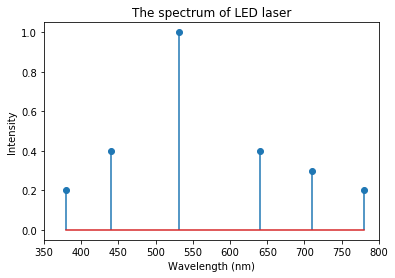

In [3]:
lam_x = np.array([0.380, 0.440, 0.532, 0.640, 0.710, 0.780])
inten_x = np.array([0.2, 0.4, 1, 0.4, 0.3, 0.2])
# inten_x = np.array([0.3, 0.5, 1, 0.6, 0.4, 0.2])

max_index = inten_x.argmax()
lam_depth = len(lam_x)

lam = lam_x[max_index]

plt.stem(lam_x*1.0e3, inten_x, use_line_collection=True)
plt.xlim(350,800)
plt.title('The spectrum of LED laser')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.show()

target image size:  2048 x 2048


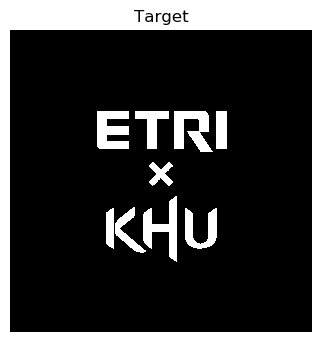

number of SLM pixels:  4194304
number of IMG pixels:  4194304
focal length:  15.398496240601505 mm
SLM pitch: 2.0 (um)
IMG pitch: 2.0 (um)
SLM size:  4096.0 (um) x 4096.0 (um)
IMG size:  4096.0 (um) x 4096.0 (um)
Fresnel number:  512.0
Refractive index:  0.6


In [4]:
%matplotlib inline

logo = plt.imread('EK_1616x1616.png')[:,:,0]
ll, mm = 1616, 2048

logo = (logo>0.5)*1

logo = np.hstack((np.zeros((ll,(mm-ll)//2)),logo,np.zeros((ll,(mm-ll)//2))))
logo = np.vstack((np.zeros(((mm-ll)//2,mm)),logo,np.zeros(((mm-ll)//2,mm))))

#logo = logo[::16,::16]
# logo = np.kron(logo, np.ones((2,2)))
logo = logo.astype(np.int8)

p = logo.shape[0]                # pxp target image
m = p*p                          # number of pixels in target image
m_b = int(np.sum(logo))          # number of bright pixels
m_d = m - m_b                    # number of dark pixels

target_coords = np.where( logo > 0 ) 
#px_ind = target_coords[0]
#py_ind = target_coords[1]

target = logo#.flatten()
print("target image size: ",p,"x",p)
plt.figure(dpi=100, figsize=(4,4))
plt.imshow(target, cmap='gray')
plt.axis('off')
plt.title('Target')
plt.show()

d_n = 0.6                        # Refractive index of Photoresist : 1.6
q   = int(1.0*p)
d   = 2.0                        # pitch: 2 micrometer
f   = p/lam*4

max_size = int(p*lam_x[-1]/lam)
max_size += max_size%2

# list of SLM pixels contained in the pupil
slm_x, slm_y = np.meshgrid( np.arange(q), np.arange(q) )
slm_x = ( slm_x - int(q/2) ) * d
slm_y = ( slm_y - int(q/2) ) * d
slm_x = slm_x.astype(np.float32)
slm_y = slm_y.astype(np.float32)

quad_phase = np.zeros((q,q), dtype=np.complex64)
quad_phase = np.exp(1j*np.pi/(lam*f)*( slm_x**2 + slm_y**2 ))

pup_ind = np.kron(range(q),np.ones(q,dtype=np.int8)), \
          np.kron(np.ones(q,dtype=np.int8),range(q))

n = pup_ind[0].shape[0]

SLM_size = d*q         # in um
IMG_size = lam*f/d     # in um
IMG_pitch = IMG_size/p # in um
print("number of SLM pixels: ",n)
print("number of IMG pixels: ",m)
print("focal length: ",f*1e-3,"mm")
print("SLM pitch:",d,"(um)")
print("IMG pitch:", IMG_pitch,"(um)")
print("SLM size: ", SLM_size, "(um) x", SLM_size, "(um)")
print("IMG size: ", IMG_size, "(um) x", IMG_size, "(um)")
print("Fresnel number: ", SLM_size**2/4/lam/f)
print("Refractive index: ", d_n)

#px = ( px_ind - int(p/2) ) * IMG_pitch
#py = ( py_ind - int(p/2) ) * IMG_pitch
#pz = ( py_ind*0 + f )


In [5]:
n_depth = 1
dz = IMG_pitch * (q//100)
quad_phase_3d = np.zeros((q,q,n_depth), dtype=np.complex64)
for i in range(n_depth):
    quad_phase_3d[:,:,i] = np.exp(1j*np.pi/(lam*(f+dz*i))*( slm_x**2 + slm_y**2 ))

# Random Superposition

RS maximum intensity:  7.6284314e-06
RS minimum intensity:  1.6456041e-14


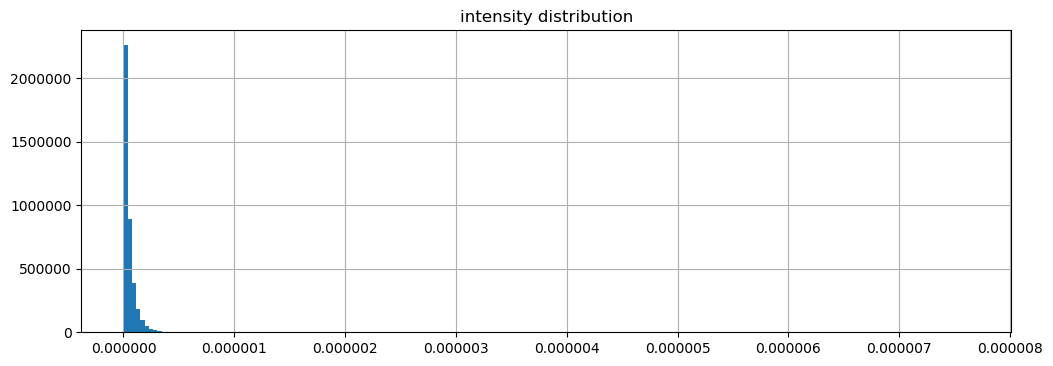

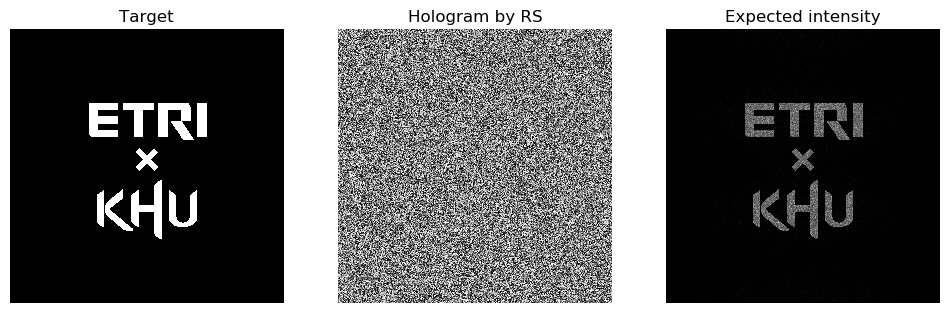

In [6]:
wf = np.zeros((q,q), dtype=np.complex64)
wf_slm = np.zeros((q,q), dtype=np.complex64)

for i in range(n_depth):
    pists = np.random.rand(m_b)*2*np.pi
    pists = pists.astype(np.float32)

    wf[target_coords] = np.exp(1j*pists)
    wf *= quad_phase_3d[:,:,i]
    wf_slm += np.fft.ifft2(wf) * np.exp(-1j*2*np.pi/lam*(f+dz*i)) / quad_phase_3d[:,:,i] * (1j*lam*(f+dz*i))

phase_rs = np.angle(wf_slm)
phase_rs = phase_rs.astype(np.float32)

del wf, wf_slm

intensity_rs = np.zeros((p,p,n_depth), dtype=np.float32)
for i in range(n_depth):
    xxx = np.exp(1j*phase_rs)*quad_phase_3d[:,:,i]
    zzz = np.fft.fft2(xxx)/n
    intensity_rs[:,:,i] = np.abs(zzz)**2
del xxx, zzz

print("RS maximum intensity: ",intensity_rs.max())
print("RS minimum intensity: ",intensity_rs.min())

plt.figure(dpi=100, figsize=(12,4))
plt.hist(intensity_rs.flatten(),200)
plt.title('intensity distribution')
plt.grid()
plt.show()

plt.figure(dpi=100, figsize=(12,4))
plt.subplot(131)
plt.imshow(target, cmap='gray')
plt.axis('off')
plt.title('Target')
plt.subplot(132)
plt.imshow(phase_rs, cmap='gray')
plt.axis('off')
plt.title('Hologram by RS')
plt.subplot(133)
plt.imshow(intensity_rs[:,:,0], cmap='gray')
plt.axis('off')
plt.title('Expected intensity')
plt.show()


# plt.figure(dpi=100, figsize=(12,40))
# for i in range(n_depth):
#     plt.subplot(10,3,i+1)
#     plt.imshow(intensity_rs[:,:,i], cmap='gray')
#     plt.axis('off')
#     plt.title('Depth')
#     plt.title('Depth '+repr(i))
# plt.show()


In [7]:
intensity_desired = np.mean(intensity_rs[:,:,0][target>0]) * 1.0
#y_d = (intensity_desired*target).astype(np.float32)
print("desired intensity: ",intensity_desired)
#print("y_d: ", np.max(y_d))

desired intensity:  3.1477420634473674e-06


In [8]:
# %env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform
# %env XLA_PYTHON_CLIENT_MEM_FRACTION=.20
gpus = jax.devices('gpu')

'''
def loss(phi):
    x = jnp.exp(1j*phi)
    loss_value = 0
    for i in range(n_depth):
        z = jnp.fft.fft2(x*quad_phase_3d[:,:,i])/n
        y = (jnp.abs(z))**2
        loss_value = loss_value + 1.0e3*n*jnp.linalg.norm(y-target*intensity_desired)**2
    return loss_value
loss = jit(loss, device=gpus[0])
grad_loss = jit(grad(loss), device=gpus[0])
'''

def loss0(phi):
    z = jnp.fft.fft2(jnp.exp(1j*phi)*quad_phase_3d[:,:,0])/n
    return 1.0e3*n*jnp.linalg.norm((jnp.abs(z))**2-target*intensity_desired)**2
grad0 = jax.grad(loss0)
loss0 = jax.jit(loss0, device=gpus[0])
grad0 = jax.jit(grad0, device=gpus[0])


env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


 iter |         loss |      norm_grad |      norm_move |     step_size
    0 |        709.4075 |          3.8264 |        367.3391 |         96.0000
    1 |        240.3217 |          3.8264 |        440.8069 |        115.2000
    2 |        160.0412 |          1.6915 |        233.8287 |        138.2400
    3 |        160.0412 |          1.1871 |         82.0494 |         69.1200
    4 |        114.9796 |          1.1871 |         98.4593 |         82.9440
    5 |        109.1964 |          0.3202 |         31.8677 |         99.5328
    6 |        104.6535 |          0.2345 |         28.0026 |        119.4394
    7 |        100.3772 |          0.2069 |         29.6489 |        143.3272
    8 |         96.4691 |          0.1924 |         33.0907 |        171.9927
    9 |         94.0179 |          0.2019 |         41.6766 |        206.3912
   10 |         94.0180 |          0.3063 |         31.6074 |        103.1956
   11 |         91.6373 |          0.3063 |         37.9288 |        12

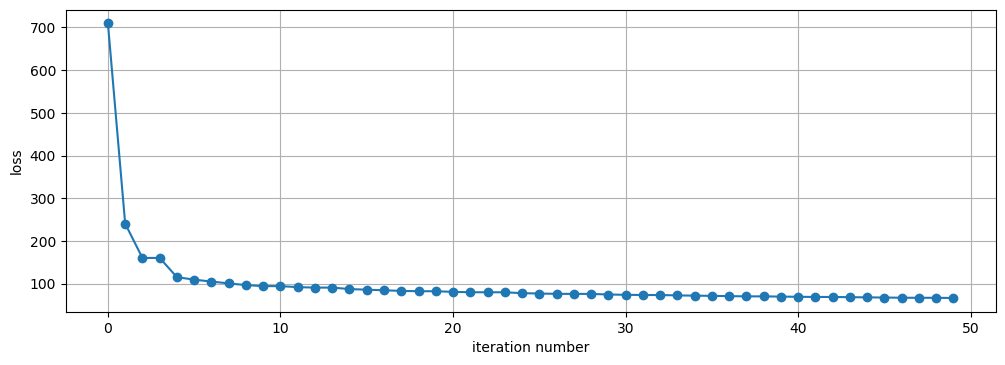

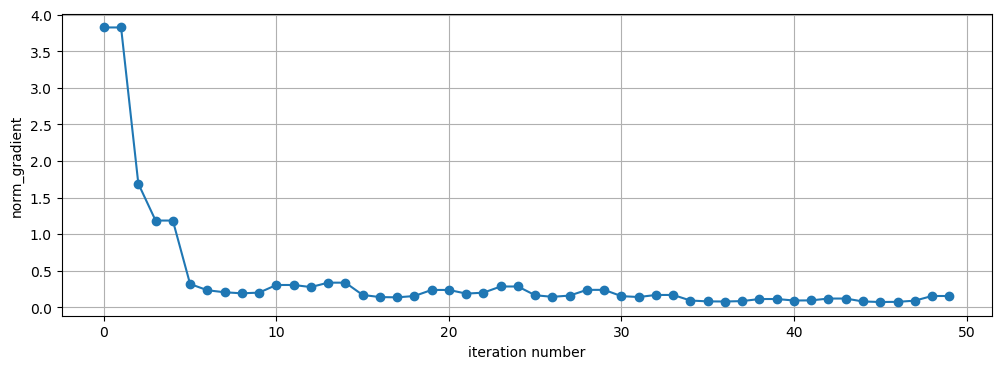

CPU times: user 3.27 s, sys: 1.27 s, total: 4.54 s
Wall time: 4.54 s


In [9]:
%%time
phi = np.angle( np.exp(1j*phase_rs) )
#phi = np.random.rand(q,q)*2*np.pi

max_iter = 50
loss_hist = np.zeros(max_iter, dtype=np.float32)
grad_hist = np.zeros(max_iter, dtype=np.float32)
move_hist = np.zeros(max_iter, dtype=np.float32)

#step_size = np.exp( 9.0-1.7*np.log(loss(phi)) )
#step_size = 10000 # q16384, loss700
#step_size = 5000 # q12288, loss700
#step_size = 2500 # q8192, loss700
#step_size = 700 # q4096, loss700
#step_size = 188 # q2048, loss700 
#step_size = 50 # q1024, loss700 
#step_size = 12 # q512, loss700 

step_size = 12*(q/512)**2



print(" iter |         loss |      norm_grad |      norm_move |     step_size")
print("======================================================================")

for i in range(max_iter):
    grad_cur = np.asarray(grad0(phi).real)
    loss_cur = np.asarray(loss0(phi))
    temp = (phi - step_size * grad_cur).astype(np.float32)
    loss_new = np.asarray(loss0(temp))
    
    if loss_new < loss_cur:
        step_size *= 1.2 
        phi = temp
        loss_cur = loss_new
    else:
        step_size *= 0.5
        
    loss_hist[i] = loss_cur
    grad_hist[i] = np.linalg.norm(grad_cur,'fro')
    move_hist[i] = step_size*grad_hist[i]
    print( "%5d |%16.4f |%16.4f |%16.4f |%16.4f" \
          % (i,loss_hist[i],grad_hist[i],move_hist[i],step_size) )
print("======================================================================")

phi_opt = np.angle( np.exp(1j*phi) )
phi_ls = copy.deepcopy(phi_opt)

plt.figure(figsize=(12,4), dpi=100)
plt.plot(range(max_iter), loss_hist, 'o-')
plt.grid()
plt.xlabel("iteration number")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12,4), dpi=100)
plt.plot(range(max_iter), grad_hist, 'o-')
plt.grid()
plt.xlabel("iteration number")
plt.ylabel("norm_gradient")
plt.show()


 
RS maximum intensity:  3.2268679e-06
RS minimum intensity:  8.133963e-15


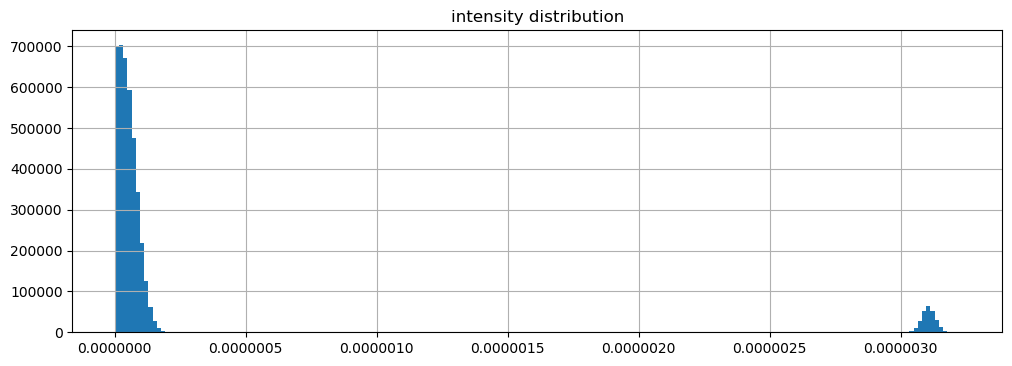

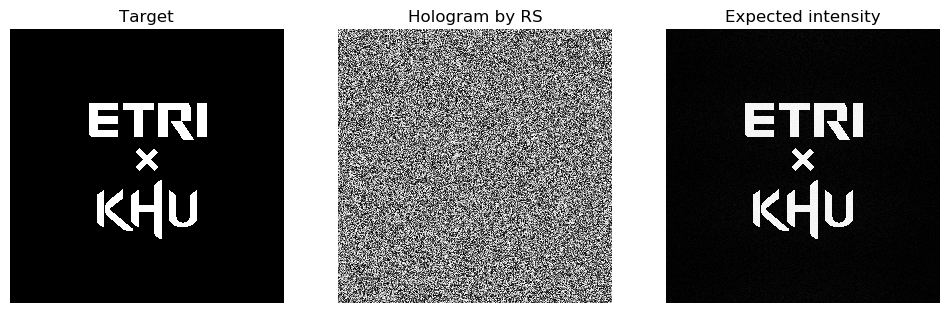

In [10]:
phase_ls = copy.deepcopy(phi_ls)

intensity_ls = np.zeros((p,p,n_depth), dtype=np.float32)
for i in range(n_depth):
    xxx = np.exp(1j*phase_ls)*quad_phase_3d[:,:,i]
    zzz = np.fft.fft2(xxx)/n
    intensity_ls[:,:,i] = np.abs(zzz)**2
del xxx, zzz

print(" ")
print("RS maximum intensity: ",intensity_ls.max())
print("RS minimum intensity: ",intensity_ls.min())

plt.figure(dpi=100, figsize=(12,4))
plt.hist(intensity_ls.flatten(),200)
plt.title('intensity distribution')
plt.grid()
plt.show()

plt.figure(dpi=100, figsize=(12,4))
plt.subplot(131)
plt.imshow(target, cmap='gray')
plt.axis('off')
plt.title('Target')
plt.subplot(132)
plt.imshow(phase_ls, cmap='gray')
plt.axis('off')
plt.title('Hologram by RS')
plt.subplot(133)
plt.imshow(intensity_ls[:,:,0], cmap='gray')
plt.axis('off')
plt.title('Expected intensity')
plt.show()

# plt.figure(dpi=100, figsize=(12,40))
# for i in range(n_depth):
#     plt.subplot(10,3,i+1)
#     plt.imshow(intensity_ls[:,:,i], cmap='gray')
#     plt.axis('off')
#     plt.title('Depth')
#     plt.title('Depth '+repr(i))
# plt.show()


In [11]:
LC_d_ls_1 = phase_ls * lam/(2*np.pi*d_n) # in um

filename = 'LC_d_ls_1_%dx%d' %(p,p)
print(filename)
# plt.imsave(filename+'.png', LC_d_ls_1, format='png', cmap='gray')
np.savetxt(filename+'.csv', LC_d_ls_1, fmt='%f')

LC_d_ls_1_2048x2048


Maximum intensity (RS):  7.6284314e-06
Maximum intensity (LS):  3.2268679e-06
Maximum intensity (disc):  3.3133997e-06
Minimum intensity (RS):  1.6456041e-14
Minimum intensity (LS):  8.133963e-15
Minimum intensity (disc):  8.023483e-15


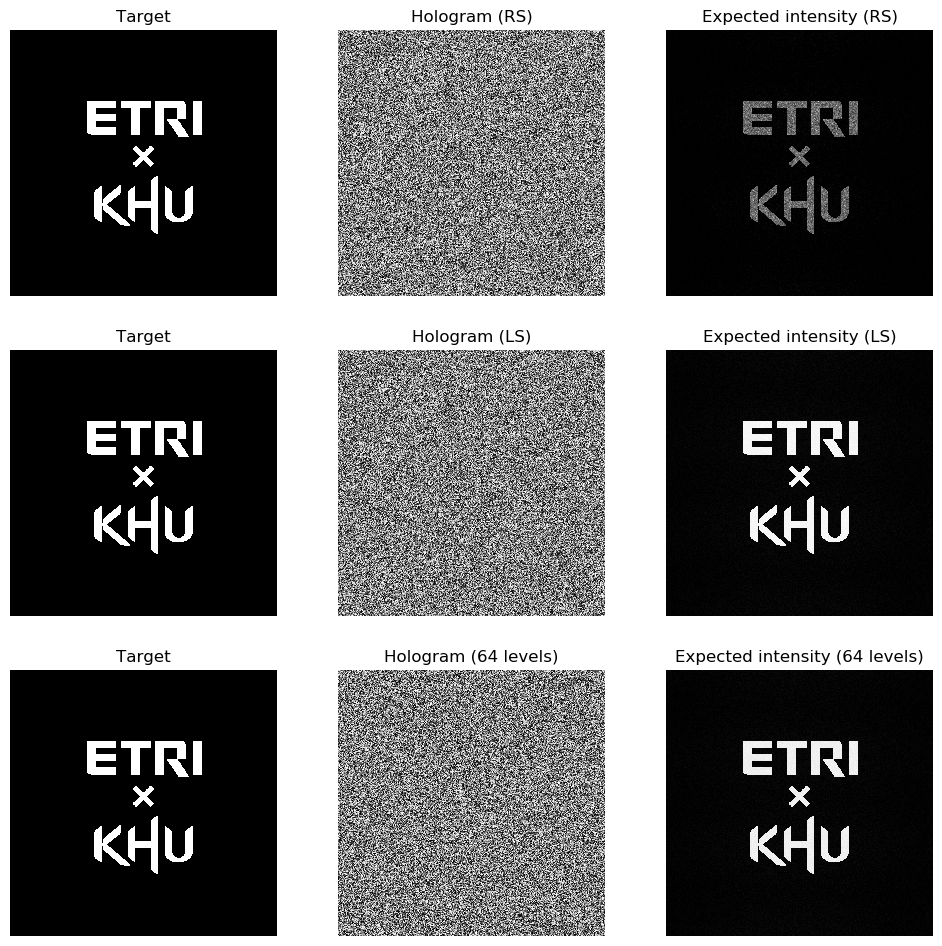

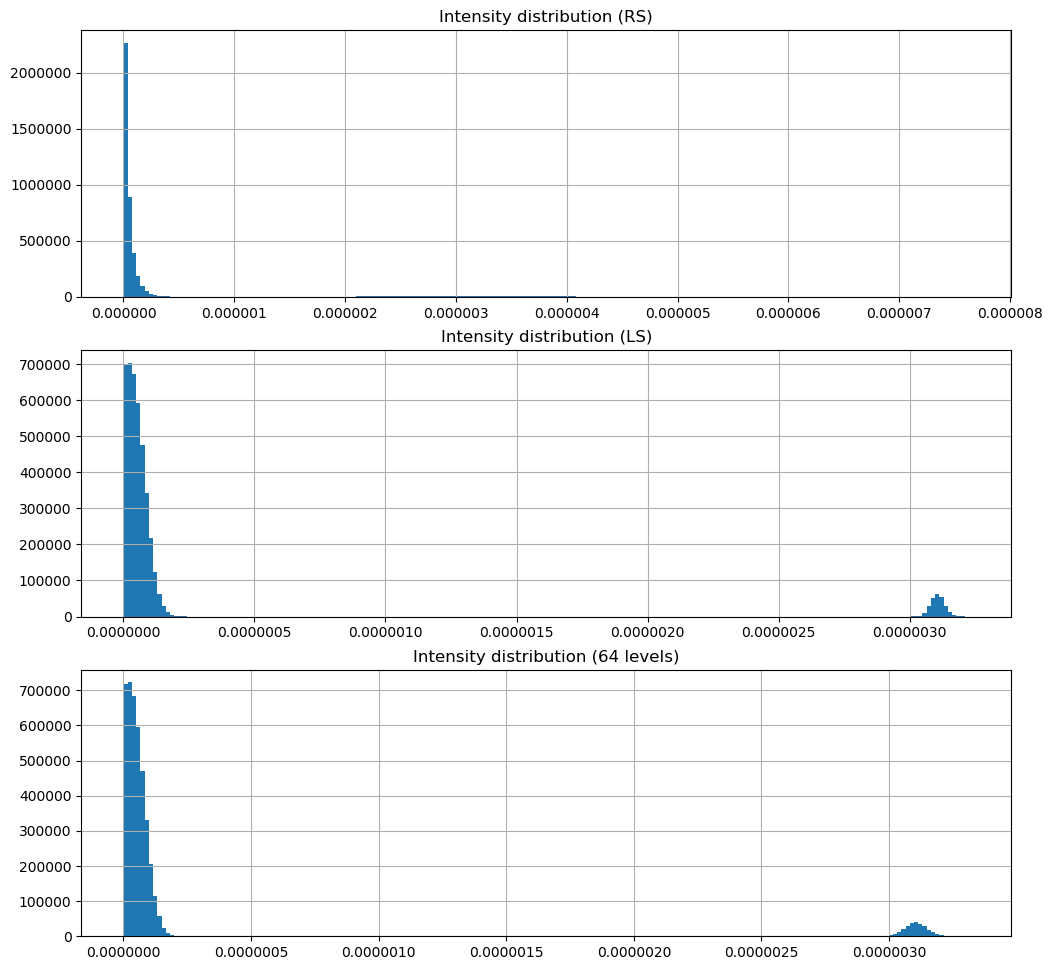

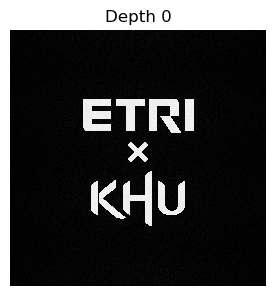

data_jhk_IMG2048x2048_SLM2048x2048_nlevels64


In [12]:
n_levels = 64
phase_c = copy.deepcopy(phase_ls)

phase_c = np.arctan2(np.sin(phase_c), np.cos(phase_c))
phase_c[phase_c<0] +=2*np.pi 

phase_disc = np.floor(phase_c/(2*np.pi)*n_levels)
phase_d = phase_disc/n_levels*2*np.pi

intensity_d = np.zeros((p,p,n_depth), dtype=np.float32)
for i in range(n_depth):
    x_d = np.exp(1j*phase_d)*quad_phase_3d[:,:,i]
    z_d = np.fft.fft2(x_d)/n
    intensity_d[:,:,i] = np.abs(z_d)**2
del x_d, z_d

print("Maximum intensity (RS): ",intensity_rs.max())
print("Maximum intensity (LS): ",intensity_ls.max())
print("Maximum intensity (disc): ",intensity_d.max())
print("Minimum intensity (RS): ",intensity_rs.min())
print("Minimum intensity (LS): ",intensity_ls.min())
print("Minimum intensity (disc): ",intensity_d.min())

plt.figure(dpi=100, figsize=(12,12))
plt.subplot(331)
plt.imshow(target, cmap='gray')
plt.axis('off')
plt.title('Target')
plt.subplot(332)
plt.imshow(phase_rs, cmap='gray')
plt.axis('off')
plt.title('Hologram (RS)')
plt.subplot(333)
plt.imshow(intensity_rs[:,:,0], cmap='gray')
plt.axis('off')
plt.title('Expected intensity (RS)')
plt.subplot(334)
plt.imshow(target, cmap='gray')
plt.axis('off')
plt.title('Target')
plt.subplot(335)
plt.imshow(phase_ls, cmap='gray')
plt.axis('off')
plt.title('Hologram (LS)')
plt.subplot(336)
plt.imshow(intensity_ls[:,:,0], cmap='gray')
plt.axis('off')
plt.title('Expected intensity (LS)')
plt.subplot(337)
plt.imshow(target, cmap='gray')
plt.axis('off')
plt.title('Target')
plt.subplot(338)
plt.imshow(phase_d, cmap='gray')
plt.axis('off')
plt.title('Hologram ('+repr(n_levels)+' levels)')
plt.subplot(339)
plt.imshow(intensity_d[:,:,0], cmap='gray')
plt.axis('off')
plt.title('Expected intensity ('+repr(n_levels)+' levels)')
plt.show()

plt.figure(dpi=100, figsize=(12,12))
plt.subplot(311)
plt.hist(intensity_rs.flatten(),200)
plt.title('Intensity distribution (RS)')
plt.grid()
plt.subplot(312)
plt.hist(intensity_ls.flatten(),200)
plt.title('Intensity distribution (LS)')
plt.grid()
plt.subplot(313)
plt.hist(intensity_d.flatten(),200)
plt.title('Intensity distribution ('+repr(n_levels)+' levels)')
plt.grid()
plt.show()

plt.figure(dpi=100, figsize=(12,40))
for i in range(n_depth):
    plt.subplot(10,3,i+1)
    plt.imshow(intensity_d[:,:,i], cmap='gray')
    plt.axis('off')
    plt.title('Depth')
    plt.title('Depth '+repr(i))
plt.show()

#phase_disc = np.zeros((q,q), dtype=int)
phase_disc = (phase_disc*256/n_levels).astype(int)
filename = 'data_jhk_IMG%dx%d_SLM%dx%d_nlevels%d' %(p,p,q,q,n_levels)
print(filename)
plt.imsave(filename+'.png', phase_disc, format='png', cmap='gray' )
np.savetxt(filename+'.csv', phase_disc, fmt='%d')


In [13]:
quad_phase_3d_1 = np.zeros((q,q,lam_depth), dtype=np.complex64)
for i in range(lam_depth):
    quad_phase_3d_1[:,:,i] = np.exp(1j*np.pi/(lam_x[i]*f)*( slm_x**2 + slm_y**2 ))
    
print('lam_depth :',lam_depth)

lam_depth : 6


In [14]:
# LC_d_ls_1

filename_1 = 'LC_d_ls_1_%dx%d' %(p,p)
LC_d_ls_1 = np.loadtxt(filename_1+'.csv', dtype=np.float32)

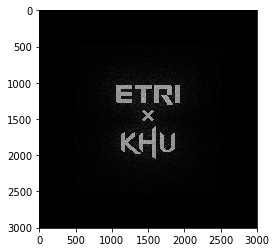

In [15]:
# LC_d_ls_1

intensity_ls_1 = np.zeros((max_size,max_size), dtype=np.float32)
for i in range(lam_depth):
    phase_ls_1 = LC_d_ls_1*2*np.pi*d_n/lam_x[i]
    xxx = np.exp(1j*phase_ls_1)*quad_phase_3d_1[:,:,i]
    zzz = inten_x[i]*np.exp(1j*2*np.pi*f/lam_x[i])/(1j*lam_x[i]*f)*np.fft.fft2(xxx)/n
    img_size = int(p*lam_x[i]/lam)
    img_size += img_size%2
    zzz = jax.image.resize(zzz, (img_size, img_size), "nearest")
    zzz = func_reshape(zzz, max_size)
    intensity_ls_1 += np.abs(zzz)**2
del xxx, zzz

plt.imshow(intensity_ls_1, cmap='gray')
plt.show()